In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
from torchinfo import summary

import os
import glob
import time
import datetime as dt
from netCDF4 import Dataset as nc_Dataset
from netCDF4 import date2num, num2date
import pandas as pd
import numpy as np
import math
import xarray as xr
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.markers import MarkerStyle
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from FunctionsAndClasses.HRRR_URMA_Datasets_AllVars import *
from FunctionsAndClasses.DefineModelAttributes import *
from FunctionsAndClasses.SR_UNet_simple import *
from FunctionsAndClasses.utils import *

In [2]:
IDX_MIN_LON=596
IDX_MIN_LAT=645
IMG_SIZE_LON=180
IMG_SIZE_LAT=180

In [3]:
varname_translation_dict = {"t2m":"t2m",
                            "d2m":"d2m",
                            "pressurf":"sp",
                            "u10m":"u10",
                            "v10m":"v10"}

urma_var_select_dict = {"t2m":{'filter_by_keys':{'typeOfLevel': 'heightAboveGround','level':2}}, 
                        "d2m":{'filter_by_keys':{'typeOfLevel': 'heightAboveGround','level':2}}, 
                        "sp":{'filter_by_keys':{'typeOfLevel': 'surface'}},
                        "u10":{'filter_by_keys':{'typeOfLevel': 'heightAboveGround','level':10}},
                        "v10":{'filter_by_keys':{'typeOfLevel': 'heightAboveGround','level':10}}}

In [4]:
test_hrrr_attrs = DefineModelAttributes(is_train=False)

### Change as needed
# test_hrrr_attrs.predictor_vars = ["pressurf"]
test_hrrr_attrs.target_vars = ["u10m", "v10m"]

test_hrrr_attrs.savename = test_hrrr_attrs.create_save_name()
test_hrrr_attrs.create_dataset()

Making dataset for model BS256_NE1000_tD_pred(t2m-d2m-pressurf-u10m-v10m)_targ(u10m-v10m)
Terrain normalization done for ['diff']
Loading predictor dataset for t2m (Year = 2024, months = 1 to 12, hours = all)
Predictor dataset data loaded. Time taken = 1.8 sec
Normalizing over all times
Normalization done. Time taken = 0.5 sec
Loading predictor dataset for d2m (Year = 2024, months = 1 to 12, hours = all)
Predictor dataset data loaded. Time taken = 1.8 sec
Normalizing over all times
Normalization done. Time taken = 0.5 sec
Loading predictor dataset for pressurf (Year = 2024, months = 1 to 12, hours = all)
Predictor dataset data loaded. Time taken = 1.9 sec
Normalizing over all times
Normalization done. Time taken = 0.5 sec
Loading predictor dataset for u10m (Year = 2024, months = 1 to 12, hours = all)
Predictor dataset data loaded. Time taken = 3.0 sec
Normalizing over all times
Normalization done. Time taken = 0.5 sec
Loading predictor dataset for v10m (Year = 2024, months = 1 to 12, h

In [5]:
test_hrrr_attrs.savename

'BS256_NE1000_tD_pred(t2m-d2m-pressurf-u10m-v10m)_targ(u10m-v10m)'

In [6]:
model = SR_UNet_simple(n_channels_in=test_hrrr_attrs.num_channels_in, n_channels_out=test_hrrr_attrs.num_channels_out)
device = torch.device("cuda")
model.to(device)
model.load_state_dict(torch.load(f"/scratch/RTMA/alex.schein/CNN_Main/Trained_models/{test_hrrr_attrs.savename}.pt", weights_only=True))

<All keys matched successfully>

In [7]:
TARG_VAR="u10m"
test_urma = xr.open_dataarray(f"/data1/projects/RTMA/alex.schein/URMA_train_test/test_urma_alltimes_{TARG_VAR}.nc", decode_timedelta=True)

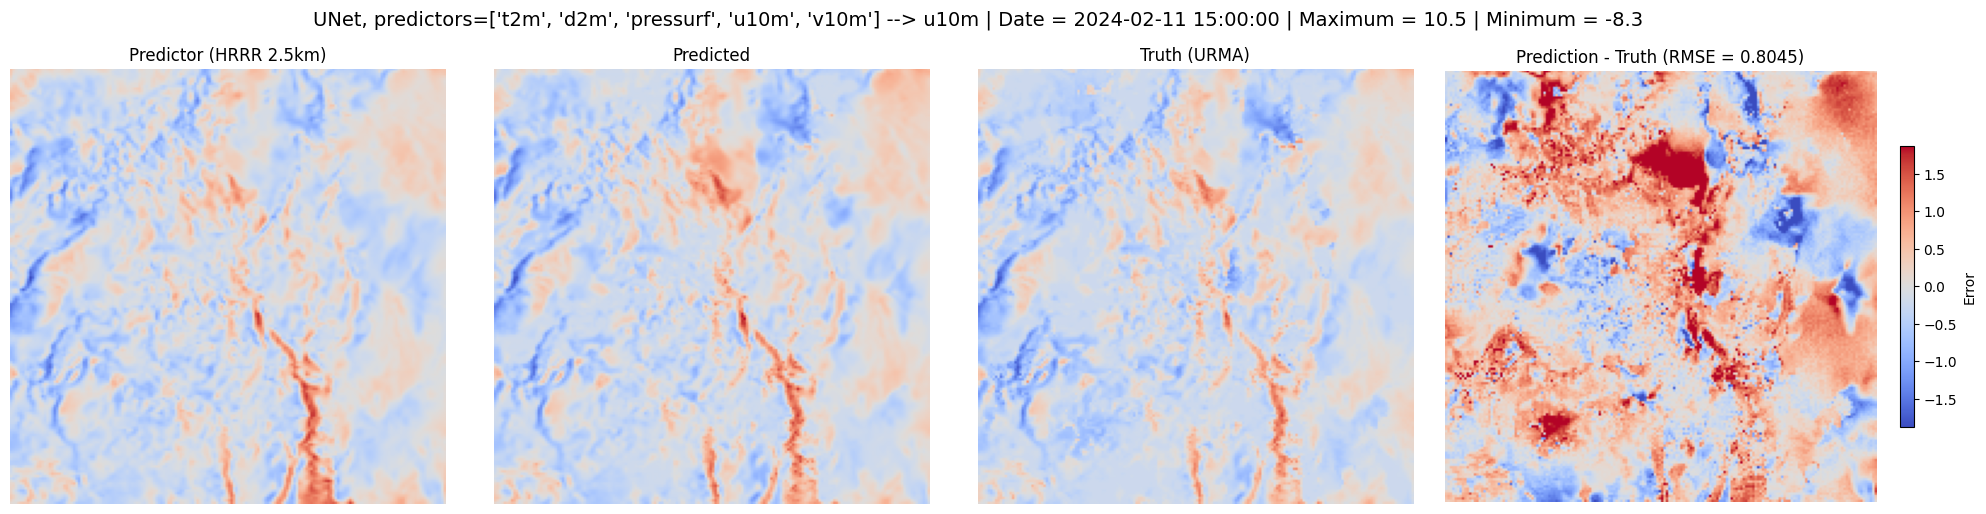

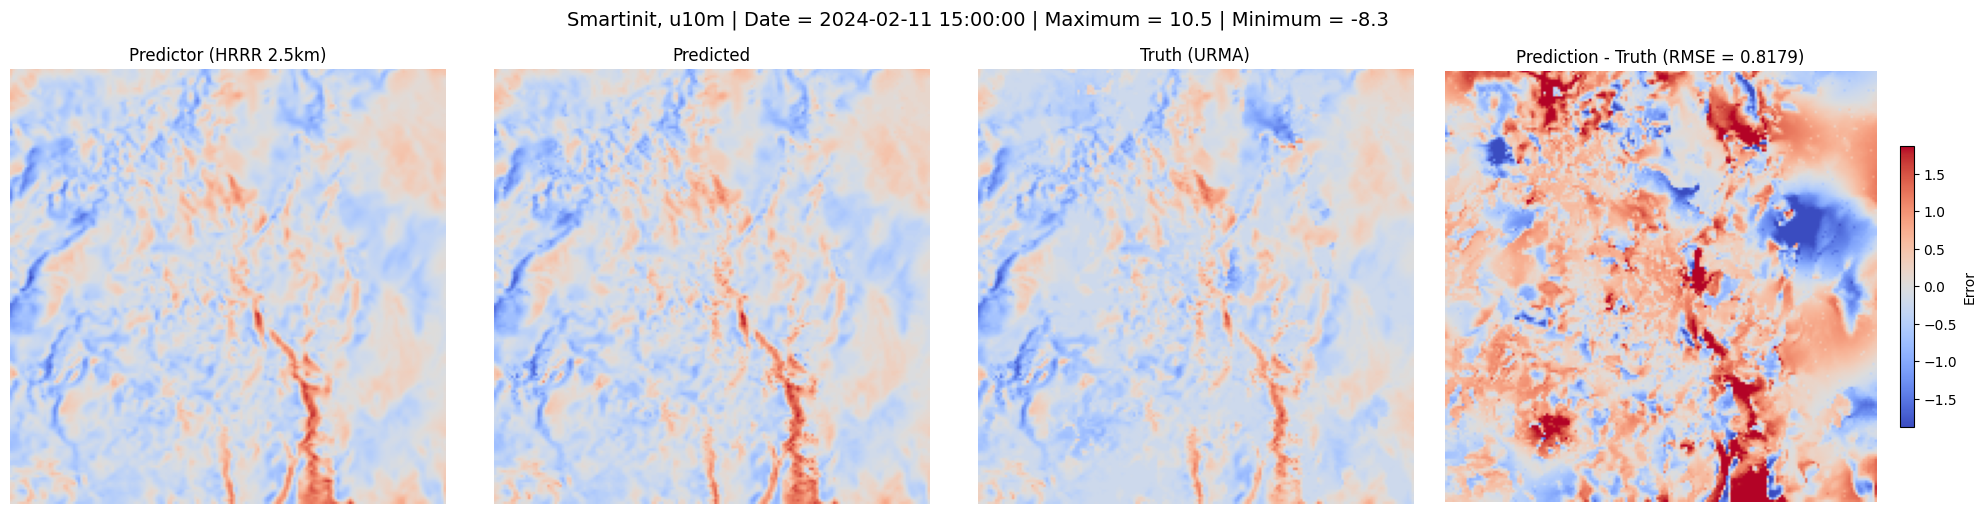

In [10]:
IDX = 999

pred, targ, model_output, dt_current = get_model_output_at_idx(model_attrs=test_hrrr_attrs, model=model, idx=IDX, pred_var=TARG_VAR, targ_var=TARG_VAR)
smartinit_dt = dt_current-dt.timedelta(hours=1) #remember, smartinit filename datetime is INITIALIZATION time, NOT valid time! 

test_smartinit = xr.open_dataset(f"/data1/projects/RTMA/alex.schein/HRRR_Smartinit_Data/hrrr_smartinit_{str(smartinit_dt.year)}{str(smartinit_dt.month).zfill(2)}{str(smartinit_dt.day).zfill(2)}_t{str(smartinit_dt.hour).zfill(2)}z_f01.grib2", 
                                 engine="cfgrib", 
                                 backend_kwargs=urma_var_select_dict[varname_translation_dict[TARG_VAR]],
                                 decode_timedelta=True)
test_smartinit_var = test_smartinit[varname_translation_dict[TARG_VAR]]
test_smartinit_var_sp_rest = test_smartinit_var.isel(y=slice(IDX_MIN_LAT, IDX_MIN_LAT+IMG_SIZE_LAT),
                                                      x=slice(IDX_MIN_LON, IDX_MIN_LON+IMG_SIZE_LON))

plot_predictor_output_truth_error(pred, model_output, targ, date_str=dt_current, title=f"UNet, predictors={test_hrrr_attrs.predictor_vars} --> {TARG_VAR}")
plot_predictor_output_truth_error(pred, test_smartinit_var_sp_rest.data, targ, date_str=dt_current, title=f"Smartinit, {TARG_VAR}")